# <center>Subitization Model</center>

### Calling Dependencies

In [1]:
import nest
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
from multiprocessing import Process
import csv
import os
import sys


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:13:33

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Nest Simulator Useful Functions

```nest.ResetKernel()``` &rarr; To reset the simulation and connections

### Understanding the Integrate and Fire Model Used in Nest Simulator

The following code will be used for testing the ```iaf_psc_alpha model``` given by nest simulator. This is a leaky integrate-and-fire model with alpha shaped input currents, where the input current is constant. It is a leaky integrate and fire neuron model with:
* a hard threshold
* a fixed refractory period
* no adaptation mechanism
* $\alpha$-shaped synaptic input currents.

#### Explanation of iaf_psc_alpha code

**The ```integrate and fire model```:**

$\tau_{\text{m}}\frac{dV_\text{m}}{dt} = -(V_{\text{m}} - E_\text{L})+ RI$

where:\
&emsp;$ I = I_{\text{syn}} + I_\text{e}$\
&emsp;$ I_{\text{syn}}$ &rarr; input current from pre-synaptic neurons\
&emsp;$I_\text{e}$ &rarr; constant input current\
&emsp;$R$ &rarr; resistance of the circuit\
&emsp;$V_\text{m}$ &rarr; membrance potential \
&emsp;$E_\text{L}$ &rarr; resting membrance potential\
&emsp;$\tau_{\text{m}}$ &rarr; membrane decay constant


A spike is emitted at timestep $t^*=t_{k+1}$ if:

$V_\text{m}(t_k) < V_{th} \quad\text{and}\quad V_\text{m}(t_{k+1})\geq V_\text{th} \;$

This membrane potential will be clamped to $V_{\text{reset}} where the refractory period is defined as $t_{\text{ref}}$:\
$V_\text{m}(t) = V_{\text{reset}} \quad\text{for}\quad t^* \leq t < t^* + t_{\text{ref}} \;,$

**Calculating the Synaptic Input, $I_{\text{syn}}$:**

$I_{\text{syn}}(t) = I_{\text{syn, ex}}(t) + I_{\text{syn, in}}(t)$

and

$I_{\text{syn, X}}(t) = \sum_{j} w_j \sum_k i_{\text{syn, X}}(t-t_j^k-d_j) \;,$

where:\
&emsp;$ I_{\text{syn, ex}}(t)$ &rarr; excitatory synaptic input\
&emsp;$ I_{\text{syn, in}}(t)$ &rarr; inhibitory synaptic input\
&emsp;$ j$ &rarr; $j$ is used to define for $\text{X}$ ($\text{X} \in \{I_{\text{syn, ex}}, I_{\text{syn, in}}(t)\}$)\
&emsp;$ k$ &rarr; indexes the spikes times of pre-synaptic neuron $j$\
&emsp;$ d_j$ &rarr; delay from pre-synaptic neuron $j$

**The post-synaptic currents are given by:**

$i_{\text{syn, X}}(t) = \frac{e}{\tau_{\text{syn, X}}} t e^{-\frac{t}{\tau_{\text{syn, X}}}} \Theta(t)$

where:\
&emsp;$Theta(t)$ &rarr; the heaviside step function. The PSCs are normalized to unit maximum, i.e., $i_{\text{syn, X}}(t= \tau_{\text{syn, X}}) = 1 \;.$

As a consequence, the total charge $q$ transferred by a single PSC depends on the synaptic time constant according to

$q = \int_0^{\infty}  i_{\text{syn, X}}(t) dt = e \tau_{\text{syn, X}} \;.$

By default, $V_\text{m}$ is not bounded from below. To limit
hyperpolarization to biophysically plausible values, set parameter
$V_{\text{min}}$ as lower bound of $V_\text{m}$.

In [9]:
print(nest.modeldict())

AttributeError: module 'nest' has no attribute 'modeldict'

#### Nest Simulation for Single Neuron with Constant Input Current

In [7]:
# Parameters
# Neuron parameters
parameters = {
        "V_m": 0.0,                   # mV
        "E_L": 0.0,                   # mV
        "V_th": 0.8,                # mV
        "V_reset": 0.0,               # mV
        "tau_syn_ex": 1000.0,         # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 10.0      ** 12,            # pA input current
        "tau_m": 50.0,                # ms membrane time constant
        "C_m": (50.0) * 10**12,       # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0.0                  # ms refractory period
    }

# Reset Network
nest.ResetKernel()
nest.set_verbosity("M_ERROR")

# Initialise neurons
neuron = nest.Create('iaf_psc_alpha', params = parameters)
spike_recorder = nest.Create('spike_recorder')
multimeter = nest.Create('multimeter')
multimeter.set(record_from=["V_m"])

# Synapse Connection Management
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spike_recorder)

# Simulation
nest.Simulate(1000)

# Plot
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
events = spike_recorder.get("events")
senders = events["senders"]
plt.figure(1)
plt.plot(ts,Vms)
plt.show()

NESTErrors.UnknownModelName: ('UnknownModelName in Create_l_i: /spike_recorder is not a known model name. Please check the modeldict for a list of available models.', 'UnknownModelName', <SLILiteral: Create_l_i>, ': /spike_recorder is not a known model name. Please check the modeldict for a list of available models.')

#### Nest Simulator for Single Neuron with Different Noise

The three methods to test here are the use of Poisson Generator, Noise Generator (input current with a Gaussian Distribution), and manually changing the input current from the parameters.

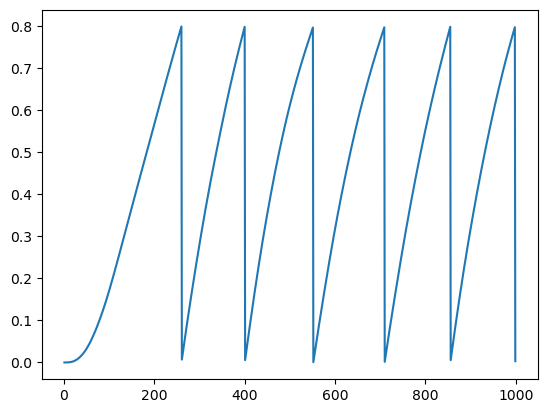

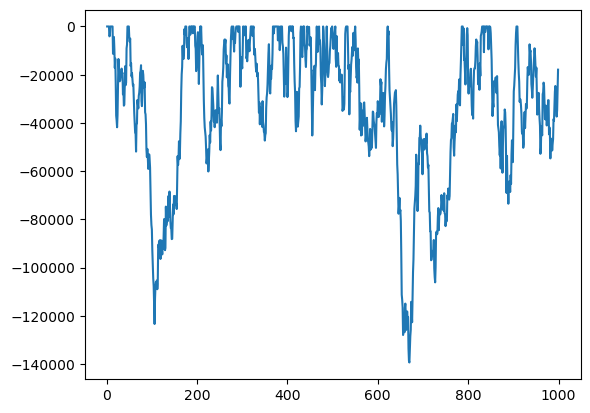

In [3]:
# Paramters
# neuron parameters
parameters = {
        "V_m": 0,                   # mV
        "E_L": 0,                   # mV
        "V_th": 0.8,                # mV
        "V_reset": 0,               # mV
        "tau_syn_ex": 50,           # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 0 * (10 ** 6),       # pA input current
        "tau_m": 200,               # ms membrane time constant
        "C_m": 70 * 10**6,          # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                  # ms refractory period
    }
# poisson generator params
poi_param = {
    "rate": 2000.0   # Hz rate of poisson generator
}
# noise generator params
white_param = {
    "mean": 0 * (10**12),  # pA mean value of the noise current
    "std": 0.5 * (10**12)  # pA the standard deviation of the noise current
}

# Testing Poisson Generator
# Reset Network (this includes the connections)
nest.ResetKernel()
nest.set_verbosity("M_ERROR")

# Initialise Neurons
poi_gen = nest.Create('poisson_generator', params=poi_param)
neuron = nest.Create('iaf_psc_alpha', params=parameters)
spike_recorder = nest.Create('spike_recorder')
multimeter = nest.Create('multimeter')
multimeter.set(record_from=["V_m"])

# Synapse Connection Management
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spike_recorder)
nest.Connect(poi_gen, neuron, syn_spec={'weight': 2 * 10**3})

# Simulate
nest.Simulate(1000)

# Plot
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
events = spike_recorder.get("events")
senders = events["senders"]
plt.figure(1)
plt.plot(ts,Vms)
plt.show()

# Testing Noise Generator
# Reset Network
nest.ResetKernel()
nest.set_verbosity("M_ERROR")

# Initialise Neurons
white_gen = nest.Create('noise_generator', params=white_param)
neuron = nest.Create('iaf_psc_alpha', params=parameters)
spike_recorder = nest.Create('spike_recorder')
multimeter = nest.Create('multimeter')
multimeter.set(record_from=["V_m"])

# Synapse Connection Management
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spike_recorder)
nest.Connect(white_gen, neuron)

# Simulate
nest.Simulate(1000)

# Plot
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
events = spike_recorder.get("events")
senders = events["senders"]
plt.figure(1)
plt.plot(ts,Vms)
plt.show()

#### Process With Input Current
The following code creates a single neuron that has an input current. The neuron's activity is adjusted based on the input current and capacitance. \
Units for function parameters:
* current: A
* capacitance: F

In [4]:
def test_current(current, capacitance):
    parameters = {
            "V_m": 0,                   # mV
            "E_L": 0,                   # mV
            "V_th": 0.8,                # mV
            "V_reset": 0,               # mV
            "tau_syn_ex": 1000,         # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            "I_e": current * (10 ** 6), # pA input current
            "tau_m": 50,                # ms membrane time constant
            "C_m": capacitance * 10**6, # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                  # ms refractory period
        }

    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()

#### Plotting Test Based On Current and Capacitance

As we increase the capacitance it requires more current to be injected. This acts like a form of threshold. \
The current tested: [0 to 100]

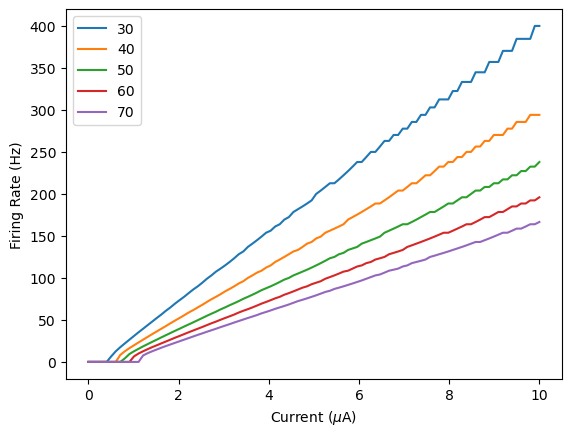

In [5]:
plt.figure()
test_range = np.linspace(0,10,100)
for c in range(30, 80, 10):
    record_fr = np.empty(0)
    for i in test_range:
        fr, _ = test_current(i, c)
        record_fr = np.append(record_fr, fr)
    plt.plot(test_range, record_fr, label=str(c))
plt.legend()
plt.xlabel("Current ($\mu$A)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### Process With Poisson Generator
The following code creates a single neuron that has a single poisson generator input. This generator can be adjusted based on its rate and the connectivity of the poisson generator to the single neuron can be adjusted based on its weight.

In [6]:
def test_random_generator(rate, weight):
    parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            # "I_e": current * (10 ** 6),   # pA input current (commented)
            "I_e": 0,                       # pA input current
            "tau_m": 7,                    # ms membrane time constant
            "C_m": 4 * 10**6,              # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': weight * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()


#### Plotting Test Based On Poisson Generator Input
The following test will determine the firing rate based on the rate generated by a Poisson generator.
The Poisson generator rate tested: [0 to 1000]

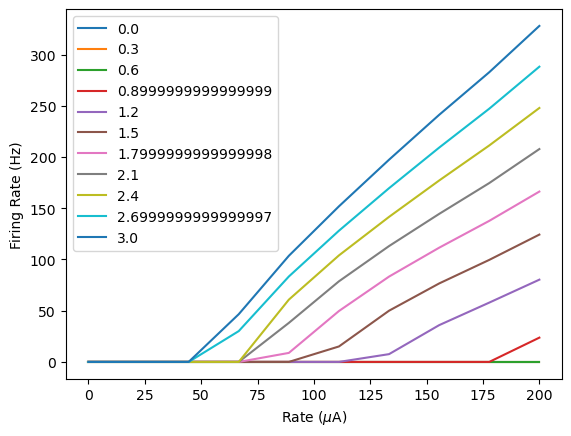

In [7]:
plt.figure()
rate_range = np.linspace(0, 200, 10)
weight_range = np.linspace(0, 3, 11)
for w in weight_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_random_generator(r, w)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(w))
plt.legend()
plt.xlabel("Rate ($\mu$A)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### How capacitance affect the fr to input ratio

In [29]:
def test_capacitance_generator(capacitance, rate):
    parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            # "I_e": current * (10 ** 6),   # pA input current (commented)
            "I_e": 0,                       # pA input current
            "tau_m": 3,                    # ms membrane time constant
            "C_m": capacitance * 10**6,     # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': 2.4 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()



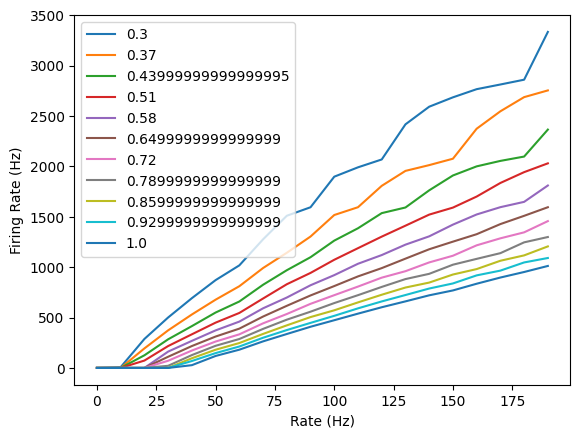

In [31]:
plt.figure()
capacitance_range = np.linspace(0.3, 1, 11)
rate_range = range(0, 200, 10)
record_fr = np.empty(0)
for c in capacitance_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_capacitance_generator(c, r)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(c))
plt.legend()
plt.xlabel("Rate (Hz)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### Test Tau

The capacitance and rate will determine how fast the model's rate can go up. In this case, I will be using the tau function to determine whether we can get a RELU like function. The idea is that when the input between two neurons cannot reach a certain threshold, this will not raise the spike at all.

In [39]:
def test_tau_generator(tau_m, rate):
    parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            # "I_e": current * (10 ** 6),   # pA input current (commented)
            "I_e": 0,                       # pA input current
            "tau_m": tau_m,                    # ms membrane time constant
            "C_m": 0.8 * 10**6,     # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': 2.4 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()



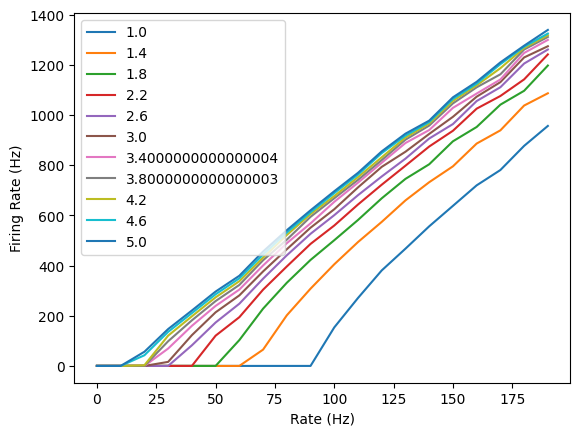

In [41]:
plt.figure()
tau_range = np.linspace(1, 5, 11)
rate_range = range(0, 200, 10)
record_fr = np.empty(0)
for tau in tau_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_tau_generator(tau, r)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(tau))
plt.legend()
plt.xlabel("Rate (Hz)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### Explanation on Gain Modulation

Referece: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2887717/

Non-linear way in which neurons combine information from two (or more) sources. It can modulate the sensitivity of neuron's input without changing the selectivity or receptive field properties.

In this case we compute the activity for the gain fields as follow:

$r = f(x_{target} - a) g(x_{perception}) $

where:\
$r = \text{amplitude response of the neuron}$ \
$x_{target} = \text{activity from a neuron in the ring attractor}$ \
$x_{perception} =\text{activity from homeostatis model}$

#### The following parameters will be used for the neuron where gain modulation is implemented to transfer spikes.
    "V_m": 0,                       # mV
    "E_L": 0,                       # mV
    "V_th": 0.8,                    # mV
    "V_reset": 0,                   # mV
    "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
    # "I_e": current * (10 ** 6),   # pA input current (commented)
    "I_e": 0,                       # pA input current
    "tau_m": 53,                    # ms membrane time constant
    "C_m": 20 * 10**6,              # pF membrane capacitance (calculated for R = 1)
    "t_ref": 0                      # ms refractory period

#### Use of two poisson generator as input to determine whether the spike can rise or not

In [2]:
def test_gain_mod(rate1, rate2, weight1, weight2):
    parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        # "I_e": current * (10 ** 6),   # pA input current (commented)
        "I_e": 0,                       # pA input current
        "tau_m": 4.2,                   # ms membrane time constant
        "C_m": 0.8 * 10**6,               # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    # poisson generator params
    poi_param_1 = {
        "rate": rate1   # Hz rate of poisson generator
    }

    poi_param_2 = {
        "rate": rate2   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen1 = nest.Create('poisson_generator', params=poi_param_1)
    poi_gen2 = nest.Create('poisson_generator', params=poi_param_2)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen1, neuron, syn_spec={'weight': weight1 * 10**3})
    nest.Connect(poi_gen2, neuron, syn_spec={'weight': weight2 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()

1.0 1.0
1.0 1.0555555555555556
1.0 1.1111111111111112
1.0 1.1666666666666667
1.0 1.2222222222222223
1.0 1.2777777777777777
1.0 1.3333333333333333
1.0 1.3888888888888888
1.0 1.4444444444444444
1.0 1.5
1.0555555555555556 1.0
1.0555555555555556 1.0555555555555556
1.0555555555555556 1.1111111111111112
1.0555555555555556 1.1666666666666667
1.0555555555555556 1.2222222222222223
1.0555555555555556 1.2777777777777777
1.0555555555555556 1.3333333333333333
1.0555555555555556 1.3888888888888888
1.0555555555555556 1.4444444444444444
1.0555555555555556 1.5
1.1111111111111112 1.0
1.1111111111111112 1.0555555555555556
1.1111111111111112 1.1111111111111112
1.1111111111111112 1.1666666666666667
1.1111111111111112 1.2222222222222223
1.1111111111111112 1.2777777777777777
1.1111111111111112 1.3333333333333333
1.1111111111111112 1.3888888888888888
1.1111111111111112 1.4444444444444444
1.1111111111111112 1.5
1.1666666666666667 1.0
1.1666666666666667 1.0555555555555556
1.1666666666666667 1.1111111111111112
1

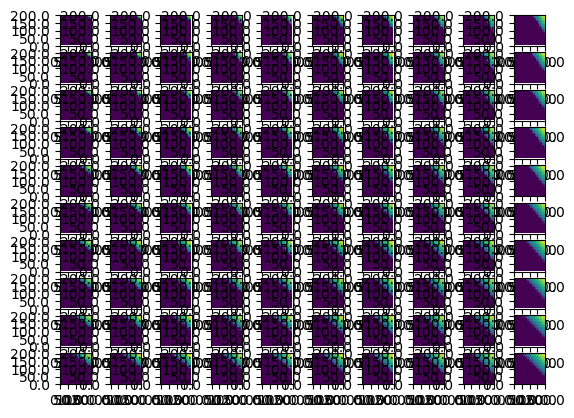

In [3]:
fig, axs = plt.subplots(10,10)
max_range = 200
min_range = 0
no_of_test = 21
w1_list = np.linspace(1, 1.5, 10)
w2_list = np.linspace(1, 1.5, 10)
for w1 in range(10):
    for w2 in range(10):
        print(w1_list[w1],w2_list[w2])
        rate1_range = np.linspace(max_range,min_range, no_of_test)
        rate2_range = np.linspace(min_range,max_range, no_of_test)
        record_fr = np.empty((len(rate1_range), len(rate2_range)))
        for r1_i in range(len(rate1_range)):
            for r2_i in range(len(rate2_range)):
                fr, _ = test_gain_mod(rate1_range[r1_i], rate2_range[r2_i], w1_list[w1], w2_list[w2])
                record_fr[r1_i][r2_i] = fr
        img = axs[w1, w2].imshow(record_fr)
        axs[w1, w2].set_xticks(np.linspace(0, no_of_test,5))
        axs[w1, w2].set_yticks(np.linspace(0, no_of_test,5))
        axs[w1, w2].set_xticklabels(np.linspace(min_range, max_range, 5))
        axs[w1, w2].set_yticklabels(labels = np.linspace(max_range, min_range, 5))
plt.show()

#### Results Gain Modulation
The following results show how the spike response will be in the case. In this case, we will be looking at the spike response when it gets input from the homeostasis warm/cold neurons and the activity from the bump attractor.

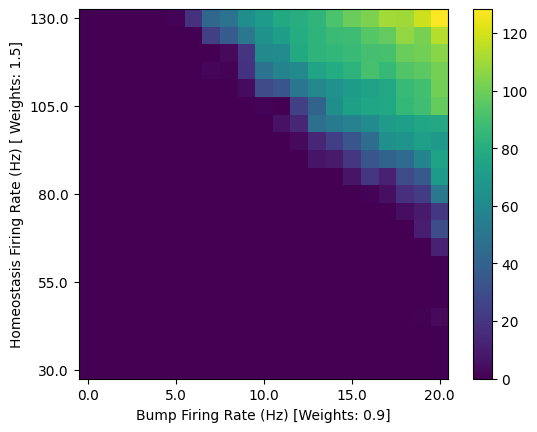

In [43]:
no_of_test = 21
bump_range = np.linspace(0, 20, no_of_test)
homeostasis_range = np.linspace(130, 30, no_of_test)
record_fr = np.empty((no_of_test, no_of_test))
for r1_i in range(no_of_test):
    for r2_i in range(no_of_test):
        fr, _ = test_gain_mod(homeostasis_range[r1_i], bump_range[r2_i], 0.4, 1.5)
        record_fr[r1_i][r2_i] = fr
plt.figure()
plt.imshow(record_fr)
plt.xlabel("Bump Firing Rate (Hz) [Weights: 0.9]")
plt.ylabel("Homeostasis Firing Rate (Hz) [ Weights: 1.5]")
plt.xticks(ticks=np.linspace(0, no_of_test - 1,5), labels=np.linspace(0, 20, 5))
plt.yticks(ticks=np.linspace(0, no_of_test - 1,5), labels=np.linspace(130, 30, 5))
plt.colorbar()
plt.show()

### Method For Integration of Gain Modulation

In [39]:
def implement_gain_mod(homeostasis_input, attractor_input):
    """
        The following method takes in two parameters to apply gain modulation to the algorithm
        homeostasis_input: The input is a neuron from the homeostasis model.
                           This can either be the higher neuron or the lower neuron
                           based on how it moves the activity in the bump attractor.
        attractor_input: The input is a neuron from the bump attractor.
                         This is connected to the bump attractor to determine how the
                         activity will be transferred.
    """
    parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 1000,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 0,                       # pA input current
        "tau_m": 4.2,                   # ms membrane time constant
        "C_m": 0.8 * 10**6,             # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)

    # Synapse Connection Management
    nest.Connect(homeostasis_input, neuron, syn_spec={'weight': 0.4 * 10**3})
    nest.Connect(attractor_input, neuron, syn_spec={'weight': 1.5 * 10**3})
    
    return neuron

### Homeostasis Model

#### Capacitance, Tau and Excitation Weight Analysis
The following tests ensure that firing remains as similar as possible during excitation.

#### Capacitance Analysis
The capacitance is analyzed to ensure that the neuron on spike can reach its peak as soon as possible. In this case, we are trying to looking at when the neuron can remain at zero when no spike is applied to it. In the case that spikes are received to the neurons, it will spike immediately with a high change in firing rate.

In [44]:
def test_homeostasis_rates(rate, capacitance):
    parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 20,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "tau_syn_in": 50,             # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
        # "I_e": current * (10 ** 6),   # pA input current (commented)
        "I_e": 0.45 * (10 ** 6),     # pA input current
        "tau_m": 7.04,                     # ms membrane time constant
        "C_m": capacitance * 10**6,               # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': 0.8 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()

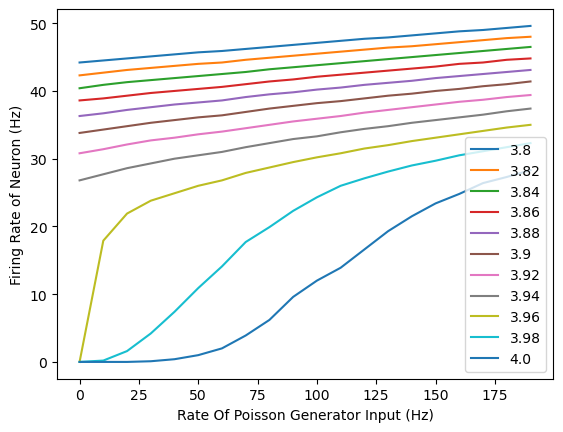

In [49]:
plt.figure()
capacitance_range = np.linspace(3.8, 4, 11)
rate_range = range(0, 200, 10)
record_fr = np.empty(0)
for c in capacitance_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_homeostasis_rates(r, c)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(c))
plt.legend()
plt.xlabel("Rate Of Poisson Generator Input (Hz)")
plt.ylabel("Firing Rate of Neuron (Hz)")
plt.show()

#### Tau Analysis
The following decay constant is analyzed to ensure that the spike can increase its change in firing

In [50]:
def test_homeostasis_rates_tau(rate, tau):
    parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 20,             # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "tau_syn_in": 50,             # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
        # "I_e": current * (10 ** 6),   # pA input current (commented)
        "I_e": 0.45 * (10 ** 6),     # pA input current
        "tau_m": tau,                     # ms membrane time constant
        "C_m": 3.96 * 10**6,               # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': 1 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()

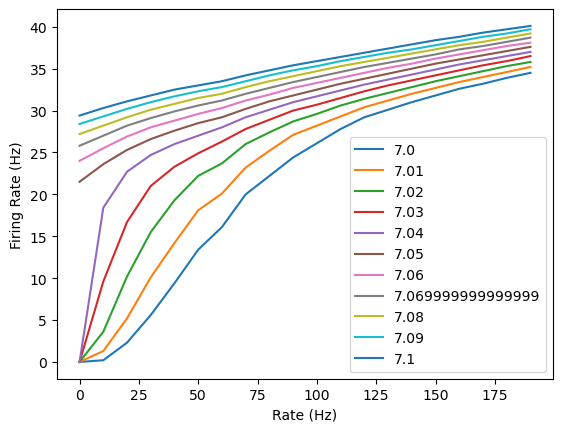

In [51]:
plt.figure()
tau_range = np.linspace(7, 7.1, 11)
rate_range = range(0, 200, 10)
record_fr = np.empty(0)
for tau in tau_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_homeostasis_rates_tau(r, tau)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(tau))
plt.legend()
plt.xlabel("Rate (Hz)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### Weight Analysis

In [75]:
def test_homeostasis_rates_weight(rate, weight):
    parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 75,               # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "tau_syn_in": 50,               # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
        # "I_e": current * (10 ** 6),   # pA input current (commented)
        "I_e": 0.45 * (10 ** 6),        # pA input current
        "tau_m": 7.04,                     # ms membrane time constant
        "C_m": 3.96 * 10**6,               # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    # poisson generator params
    poi_param = {
        "rate": rate   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen = nest.Create('poisson_generator', params=poi_param)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen, neuron, syn_spec={'weight': weight * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()

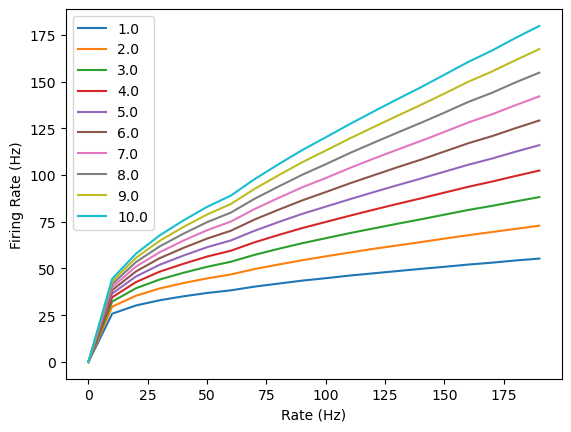

In [76]:
plt.figure()
weight_range = np.linspace(1, 10, 10)
rate_range = range(0, 200, 10)
record_fr = np.empty(0)
for w in weight_range:
    record_fr = np.empty(0)
    for r in rate_range:
        fr, _ = test_homeostasis_rates_weight(r, w)
        record_fr = np.append(record_fr, fr)
    plt.plot(rate_range, record_fr, label=str(w))
plt.legend()
plt.xlabel("Rate (Hz)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

#### Test Homeostasis

In [53]:
def test_homeostasis(rate1, rate2, in_weight, tau_in = 1):
    parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 75,               # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "tau_syn_in": 50,               # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 0.45 * (10 ** 6),        # pA input current
        "tau_m": 7.04,                     # ms membrane time constant
        "C_m": 3.96 * 10**6,               # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    # poisson generator params
    poi_param_1 = {
        "rate": rate1   # Hz rate of poisson generator
    }

    poi_param_2 = {
        "rate": rate2   # Hz rate of poisson generator
    }
    
    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neurons
    neuron = nest.Create('iaf_psc_alpha', params = parameters)
    poi_gen1 = nest.Create('poisson_generator', params=poi_param_1)
    poi_gen2 = nest.Create('poisson_generator', params=poi_param_2)
    spike_recorder = nest.Create('spike_recorder')
    multimeter = nest.Create('multimeter')
    multimeter.set(record_from=["V_m"])

    # Synapse Connection Management
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(poi_gen1, neuron, syn_spec={'weight': 6 * 10**3})
    nest.Connect(poi_gen2, neuron, syn_spec={'weight': in_weight * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder.get("events")["times"])/10, multimeter.get()

#### Understanding the spike responses

The following section analyzes the spike response to the neurons. In this case, we will be looking at whether the neuron can complete inhibit when one neuron spikes more than the other.

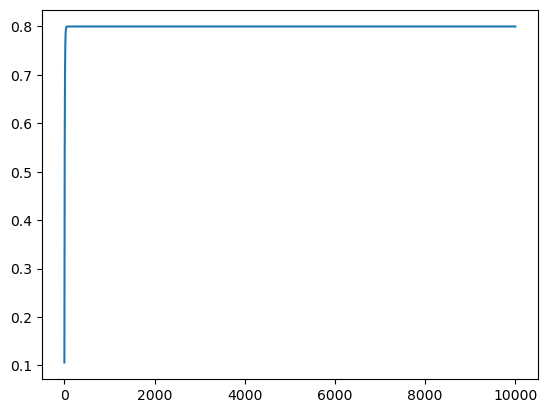

0.0


In [54]:
# Plot
fr, dmm = test_homeostasis(0, 0, -60, 10)
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
plt.figure(1)
plt.plot(ts, Vms)
plt.show()
print(fr)

-5.0 8.0
-5.0 8.444444444444445
-5.0 8.88888888888889
-5.0 9.333333333333334
-5.0 9.777777777777779
-5.0 10.222222222222221
-5.0 10.666666666666666
-5.0 11.11111111111111
-5.0 11.555555555555555
-5.0 12.0
-5.555555555555555 8.0
-5.555555555555555 8.444444444444445
-5.555555555555555 8.88888888888889
-5.555555555555555 9.333333333333334
-5.555555555555555 9.777777777777779
-5.555555555555555 10.222222222222221
-5.555555555555555 10.666666666666666
-5.555555555555555 11.11111111111111
-5.555555555555555 11.555555555555555
-5.555555555555555 12.0
-6.111111111111111 8.0
-6.111111111111111 8.444444444444445
-6.111111111111111 8.88888888888889
-6.111111111111111 9.333333333333334
-6.111111111111111 9.777777777777779
-6.111111111111111 10.222222222222221
-6.111111111111111 10.666666666666666
-6.111111111111111 11.11111111111111
-6.111111111111111 11.555555555555555
-6.111111111111111 12.0
-6.666666666666667 8.0
-6.666666666666667 8.444444444444445
-6.666666666666667 8.88888888888889
-6.666666

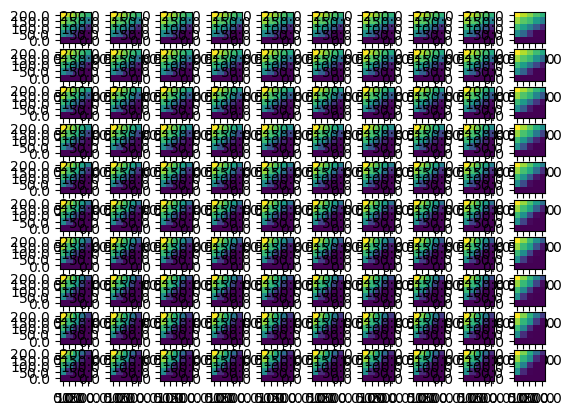

In [88]:
fig, axs = plt.subplots(10,10)
no_of_test = 5
rate1_range = np.linspace(200, 0, no_of_test)
rate2_range = np.linspace(0, 200, no_of_test)
record_fr = np.empty((len(rate1_range), len(rate2_range)))
weight_range = np.linspace(-5, -10, 10)
tau_in_range = np.linspace(8, 12, 10)
for weight_i in range(len(weight_range)):
    for tau_in_i in range(len(tau_in_range)):
        print(weight_range[weight_i], tau_in_range[tau_in_i])
        for r1_i in range(len(rate1_range)):
            for r2_i in range(len(rate2_range)):
                fr, _ = test_homeostasis(rate1_range[r1_i], rate2_range[r2_i], weight_range[weight_i], tau_in_range[tau_in_i])
                record_fr[r1_i][r2_i] = fr
        img = axs[weight_i, tau_in_i].imshow(record_fr)
        axs[weight_i, tau_in_i].set_xticks(np.linspace(0, no_of_test - 1,5))
        axs[weight_i, tau_in_i].set_yticks(np.linspace(0, no_of_test - 1,5))
        axs[weight_i, tau_in_i].set_xticklabels(np.linspace(0, 200, 5))
        axs[weight_i, tau_in_i].set_yticklabels(labels = np.linspace(200, 0, 5))
plt.show()

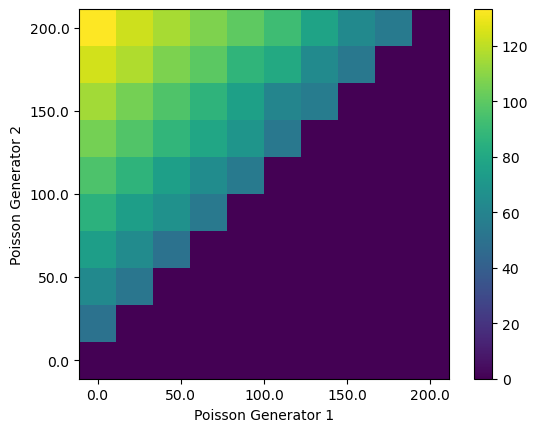

In [55]:
no_of_test = 10
rate1_range = np.linspace(200, 0, no_of_test)
rate2_range = np.linspace(0, 200, no_of_test)
record_fr = np.empty((len(rate1_range), len(rate2_range)))
for r1_i in range(len(rate1_range)):
    for r2_i in range(len(rate2_range)):
        fr, _ = test_homeostasis(rate1_range[r1_i], rate2_range[r2_i], -8, 10)
        if fr < 50:
            fr = 0
        record_fr[r1_i][r2_i] = fr
plt.figure()
plt.imshow(record_fr)
plt.xlabel("Poisson Generator 1")
plt.ylabel("Poisson Generator 2")
plt.xticks(ticks=np.linspace(0, no_of_test - 1,5), labels=np.linspace(0, 200, 5))
plt.yticks(ticks=np.linspace(0, no_of_test - 1,5), labels=np.linspace(200, 0, 5))
plt.colorbar()
plt.show()

### Method For Integration of Homeostasis Model

In the Hammel Model, warm-sensitive neurons translate temperature into activity where the perception determines the change in itself. The temperature-sensitive neurons acts as a reference point for the activity. Thus, these neurons define how perception of temperature from the environment will determine which mechanism to activate. This is done through interplay of excitation and inhibition onto the cold-sensitive neurons and warm-sensitive neurons. These neurons will produce activity based on whether to produce heat or maintain heatloss.

In our case, we will be focusing mainly on the cold-sensitive neurons and warm-sensitive neurons. This will focus on how perception will change the mechanism to be applied onto the system. In the hammel model, the reference point is required and thus the reason why it needs the temperature insensitive neurons for it. Here, we will be using the two sensitivity neurons to produce spikes with firing rate that suits our negative feedback control mechanism.

In [29]:
def implement_homeostasis(external_input, internal_input):
    """
        The following method involves connect to two types of neuron: external and internal.
        If external is higher than internal, this will produce more spikes in high neuron.
        If internal is higher than internal, this will produce more spikes in low neuron.
        external_input: The following is an external neuron. This is the neuron that produces
                        spike in relation to input from the external environment. In this case,
                        we will be inputting spikes based on the number it perceives.
        internal_input: The following is an internal neuron. This is the neuron that produces
                        spike in relation to the bump activity from the ring attractor model.
    """
    parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 75,               # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "tau_syn_in": 50,               # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 0.45 * (10 ** 6),        # pA input current
        "tau_m": 7.04,                  # ms membrane time constant
        "C_m": 3.96 * 10**6,            # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    # Initialise neurons
    high_neuron = nest.Create('iaf_psc_alpha', params = parameters)
    low_neuron = nest.Create('iaf_psc_alpha', params = parameters)

    # Synapse Connection Management
    nest.Connect(external_input, high_neuron, syn_spec={'weight': 6 * 10**3})
    nest.Connect(internal_input, high_neuron, syn_spec={'weight': -8 * 10**3})
    nest.Connect(internal_input, low_neuron, syn_spec={'weight': 6 * 10**3})
    nest.Connect(external_input, low_neuron, syn_spec={'weight': -8 * 10**3})

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return high_neuron, low_neuron

#### Test Homeostasis Model with Gain Modulation

In [31]:
def test_homeostasis_gain(rate_ex, rate_in, rate_bump):

    # poisson generator params
    poi_param_ex = {
        "rate": rate_ex   # Hz rate of poisson generator
    }

    poi_param_in = {
        "rate": rate_in   # Hz rate of poisson generator
    }
    
    poi_param_bump = {
        "rate": rate_bump   # Hz rate of poisson generator
    }

    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neuron
    poi_gen_ex = nest.Create('poisson_generator', params=poi_param_ex)
    poi_gen_in = nest.Create('poisson_generator', params=poi_param_in)
    poi_gen_bump = nest.Create('poisson_generator', params=poi_param_bump)

    # Initialise models
    high_neuron, low_neuron = implement_homeostasis(poi_gen_ex, poi_gen_in)
    gain_mod_high = implement_gain_mod(high_neuron, poi_gen_bump)
    gain_mod_low = implement_gain_mod(low_neuron, poi_gen_bump)
    spike_recorder_high = nest.Create('spike_recorder')
    spike_recorder_low = nest.Create('spike_recorder')

    # Measurement Connection Management
    nest.Connect(gain_mod_high, spike_recorder_high)
    nest.Connect(gain_mod_low, spike_recorder_low)

    # Simulation
    nest.Simulate(10000)
    
    # print(spike_recorder.get("events")["times"])
    return len(spike_recorder_high.get("events")["times"])/10, len(spike_recorder_low.get("events")["times"])/10

#### Results of implementing homeostasis to the gain modulation
The following results show how the gain modulation is affected by homeostasis and thus transfers activity from one bump to the other.

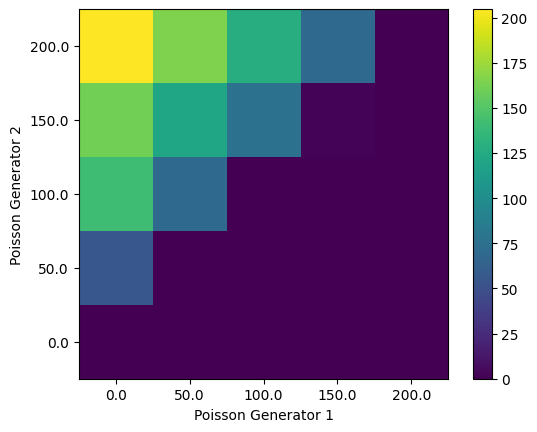

In [40]:
no_of_test = 5
rate1_range = np.linspace(200, 0, no_of_test)
rate2_range = np.linspace(0, 200, no_of_test)
record_fr = np.empty((len(rate1_range), len(rate2_range)))
for r1_i in range(len(rate1_range)):
    for r2_i in range(len(rate2_range)):
        fr, _ = test_homeostasis_gain(rate1_range[r1_i], rate2_range[r2_i], 20)
        record_fr[r1_i][r2_i] = fr
plt.figure()
plt.imshow(record_fr)
plt.xlabel("Poisson Generator 1")
plt.ylabel("Poisson Generator 2")
plt.xticks(ticks=np.linspace(0, no_of_test - 1,5), labels=np.linspace(0, 200, 5))
plt.yticks(ticks=np.linspace(0, no_of_test - 1,5), labels=np.linspace(200, 0, 5))
plt.colorbar()
plt.show()

### Ring Attractor

#### Ring Attractor Parameters

#### Defining the Neuronal Distance

In [4]:
population_size = 100
max_distance = 50

def neuron_distance_1(size = 10, max_distance = 20):
    if size % 2 == 0:
        distance = np.append(np.linspace(0, max_distance, int(size/2)), np.linspace(max_distance, 0, int(size/2)))
    else:
        distance = np.append(np.linspace(0, max_distance - (max_distance/((size - 1)/2)), int(np.floor(size/2))), np.append(np.array([max_distance]), np.linspace(max_distance - (max_distance/((size-1)/2)), 0, int(np.floor(size/2)))))
    return distance

def neuron_distance(size = 10, max_distance = 20):
    if size % 2 == 0:
        distance = np.append(0, np.linspace(0, max_distance, int(size/2) + 1)[1:(int(size/2))])
        distance = np.append(distance, max_distance)
        distance = np.append(distance, np.linspace(max_distance, 0, int(size/2) + 1)[1:(int(size/2))])
    else:
        distance = np.append(0, np.linspace(0, max_distance, int(size/2) + 1)[1:])
        distance = np.append(distance, np.linspace(max_distance, 0, int(size/2) + 1)[:(int(size/2))])
    return distance

In [4]:
print(neuron_distance(size=9, max_distance=1))

[0.   0.25 0.5  0.75 1.   1.   0.75 0.5  0.25]


#### Defining the Weights

In [5]:
def get_weight(distance, size, model = 0):
    """
        calculate the weight where n1 is pre-synaptic and n2 is post-synaptic
    """
    # replication of the weight model from the paper
    if model == 0:
        w = lambda a, z: (1.0/np.sqrt(a*np.pi))*np.exp(-z**2/a)
        J = lambda z: 5 * (1.1 * w(1/28, z) - w(1/20,z))
        weight_calc = lambda k: J(np.abs(k)/ size)
        weight = weight_calc(distance)
    # use of modified model from Gurstner book
    elif model == 1:
        sd1 = 10/(population_size/100)
        sd2 = 5/(population_size/100)
        w = lambda sd1, sd2, x: ((sd2 * np.exp((-(x**2))/(2*(sd1**2)))) - (sd1 * np.exp((-(x**2))/(2*(sd2**2)))))/(sd2 - sd1)
        weight = 3 * w(sd1, sd2, distance)
    return np.around(weight, 3)

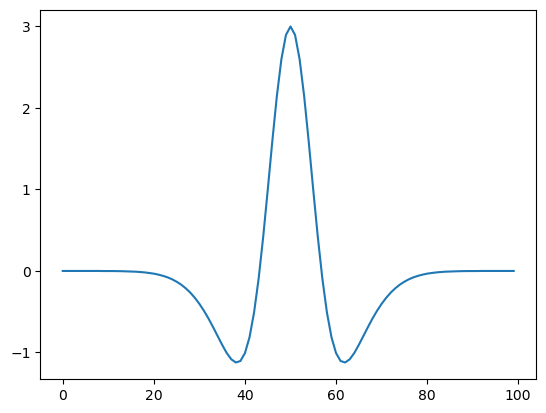

In [65]:
distances = neuron_distance(size=population_size, max_distance=max_distance)
weight_list = []
for d in distances[50:]:
    weight_list.append(get_weight(d, population_size, model = 1))
for d in distances[:50]:
    weight_list.append(get_weight(d, population_size, model = 1))
plt.figure()
plt.plot(weight_list)

#### Defining the weights and connections

In [10]:
def ring_connection(model=0):
    if model == 0:
        ring_parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 15,               # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            "tau_syn_in": 50,               # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
            "I_e": 0.45 * (10 ** 6),        # pA input current
            "tau_m": 7.04,                  # ms membrane time constant
            "C_m": 3.96 * 10**6,            # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }
    elif model == 1:
        ring_parameters = {
            "V_m": 0,                       # mV
            "E_L": 0,                       # mV
            "V_th": 0.8,                    # mV
            "V_reset": 0,                   # mV
            "tau_syn_ex": 27,               # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
            "tau_syn_in": 50,               # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
            "I_e": 0.45 * (10 ** 6),        # pA input current
            "tau_m": 7.04,                  # ms membrane time constant
            "C_m": 3.96 * 10**6,            # pF membrane capacitance (calculated for R = 1)
            "t_ref": 0                      # ms refractory period
        }
    neurons = []
    spike_recorders = []
    multimeters = []
    # Create neurons and add to list first
    for _ in range(population_size):
        # Initialise neurons and recorders
        neuron = nest.Create("iaf_psc_alpha", params=ring_parameters)
        spike_recorder = nest.Create('spike_recorder')
        multimeter = nest.Create('multimeter')
        multimeter.set(record_from=["V_m"])

        # Synapse Connection Management
        nest.Connect(multimeter, neuron)
        nest.Connect(neuron, spike_recorder)

        # Save to list
        neurons.append(neuron)
        spike_recorders.append(spike_recorder)
        multimeters.append(multimeter)
    distances = neuron_distance(size=population_size, max_distance=max_distance)
    index_readjust = lambda x, y, max: x + y if (x + y) < max else (x + y) - max   # redefine current index to connect to
    for i_neuron in range(len(neurons)):
        for i_to_conn in range(len(distances)):
            index_to_conn = index_readjust(i_to_conn, i_neuron, len(neurons))
            syn_dict = {"weight": get_weight(distances[i_to_conn], population_size, model=model)}
            nest.Connect(neurons[i_neuron], neurons[index_to_conn], syn_spec=syn_dict)
    return neurons, spike_recorders, multimeters

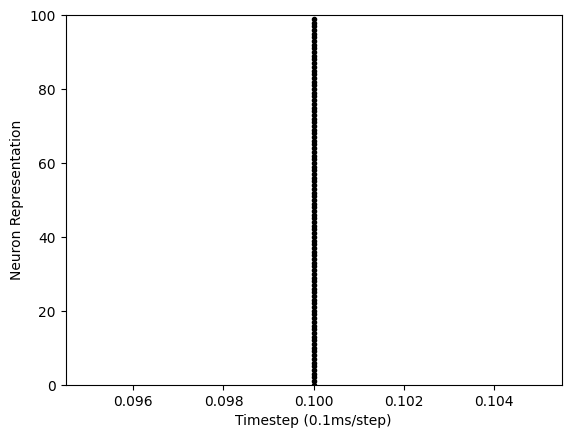

In [11]:
def single_plot_ring():

    # poisson generator params
    poi_param = {
        "rate": 200   # Hz rate of poisson generator
    }

    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")
    
    # Initialise connection
    neurons, spike_recorders, multimeters = ring_connection(model=1)
    # poi_gen1 = nest.Create('poisson_generator', params=poi_param)
    # poi_gen2 = nest.Create('poisson_generator', params=poi_param)
    # poi_gen3 = nest.Create('poisson_generator', params=poi_param)
    # for neuron in neurons[20:30]:
    #     nest.Connect(poi_gen1, neuron, syn_spec={'weight': 5 * 10**3})

    # for neuron in neurons[30:40]:
    #     nest.Connect(poi_gen2, neuron, syn_spec={'weight': 5 * 10**3})

    # for neuron in neurons[40:50]:
    #     nest.Connect(poi_gen3, neuron, syn_spec={'weight': 5 * 10**3})

    # poi_gen2.rate = 0
    # poi_gen3.rate = 0

    # nest.Simulate(1000)

    # poi_gen2.rate = 200
    # poi_gen1.rate = 0
    # poi_gen3.rate = 0

    # nest.Simulate(1000)

    # poi_gen2.rate = 0
    # poi_gen1.rate = 0
    # poi_gen3.rate = 200

    # nest.Simulate(1000)

    # poi_gen2.rate = 0
    # poi_gen1.rate = 0
    # poi_gen3.rate = 0

    nest.Simulate(10000)
    
    plt.figure(2)
    i = 0
    for spike_record in spike_recorders:
        events = spike_record.get("events")
        ts = events["times"]
        if len(ts[ts>12000]) > 0:
            print(len(ts[ts>12000]))
        plt.plot(ts, np.full(shape=len(ts),fill_value=i,dtype=np.int64), "k.")
        i += 1
    plt.ylim([0, population_size])
    plt.xlabel("Timestep (0.1ms/step)")
    plt.ylabel("Neuron Representation")
    plt.show()
single_plot_ring()

In [ ]:
def implement_bump_attractor():
    
    ring_parameters = {
        "V_m": 0,                       # mV
        "E_L": 0,                       # mV
        "V_th": 0.8,                    # mV
        "V_reset": 0,                   # mV
        "tau_syn_ex": 27,               # ms rise time of the excitatory synaptic alpha function (i.e. to see the current for each spike decays)
        "tau_syn_in": 50,               # ms rise time of the inhibitory synaptic alpha function (i.e. to see the current for each spike decays)
        "I_e": 0.45 * (10 ** 6),        # pA input current
        "tau_m": 7.04,                  # ms membrane time constant
        "C_m": 3.96 * 10**6,            # pF membrane capacitance (calculated for R = 1)
        "t_ref": 0                      # ms refractory period
    }

    neurons = []
    spike_recorders = []
    multimeters = []
    # Create neurons and add to list first
    for _ in range(population_size):
        # Initialise neurons and recorders
        neuron = nest.Create("iaf_psc_alpha", params=ring_parameters)
        spike_recorder = nest.Create('spike_recorder')
        multimeter = nest.Create('multimeter')
        multimeter.set(record_from=["V_m"])

        # Synapse Connection Management
        # Thalamus Connection
        for neuron_i in range(len(neurons)):
            # thalamus high connection
            nest.Connect(thalamus_highs[neuron_i], neurons[neuron_i], syn_spec={'weight': 5 * 10**3})
            neuron_i_prev = lambda i: (i - 1) if (i - 1) > 0 else (len(neurons) - 1)
            nest.Connect(neurons[neuron_i_prev(neuron_i)], thalamus_highs[neuron_i])
            # thalamus low connection
            nest.Connect(thalamus_lows[neuron_i], neurons[neuron_i], syn_spec={'weight': 5 * 10**3})
            neuron_i_next = lambda i: (i + 1) if (i + 1) < (len(neurons) - 1) else 0
            nest.Connect(neurons[neuron_i_next(neuron_i)], thalamus_lows[neuron_i])
        # recorders
        nest.Connect(multimeter, neuron)
        nest.Connect(neuron, spike_recorder)

        # Save to list
        neurons.append(neuron)
        spike_recorders.append(spike_recorder)
        multimeters.append(multimeter)
    distances = neuron_distance(size=population_size, max_distance=max_distance)
    index_readjust = lambda x, y, max: x + y if (x + y) < max else (x + y) - max   # redefine current index to connect to
    for i_neuron in range(len(neurons)):
        for i_to_conn in range(len(distances)):
            index_to_conn = index_readjust(i_to_conn, i_neuron, len(neurons))
            syn_dict = {"weight": get_weight(distances[i_to_conn], population_size, model=model)}
            nest.Connect(neurons[i_neuron], neurons[index_to_conn], syn_spec=syn_dict)
    return neurons, spike_recorders, multimeters, thalamus_lows, thalamus_highs

#### Full Implementation

In [ ]:
def full_implementation(rate_ex, rate_in):
        # poisson generator params
    poi_param_ex = {
        "rate": rate_ex   # Hz rate of poisson generator
    }

    poi_param_in = {
        "rate": rate_in   # Hz rate of poisson generator
    }

    # Reset Network
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")

    # Initialise neuron
    poi_gen_ex = nest.Create('poisson_generator', params=poi_param_ex)
    poi_gen_in = nest.Create('poisson_generator', params=poi_param_in)

    # Initialise models
    high_neuron, low_neuron = implement_homeostasis(poi_gen_ex, poi_gen_in)
    gain_mod_high = implement_gain_mod(high_neuron, poi_gen_bump)
    gain_mod_low = implement_gain_mod(low_neuron, poi_gen_bump)
    spike_recorder_high = nest.Create('spike_recorder')
    spike_recorder_low = nest.Create('spike_recorder')

    # Measurement Connection Management
    nest.Connect(gain_mod_high, spike_recorder_high)
    nest.Connect(gain_mod_low, spike_recorder_low)

    # Simulation
    nest.Simulate(10000)